In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

messages = pd.read_csv('SMSSpamCollection', sep='\t',
                       names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [5]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Let's do some visualisation

<AxesSubplot: ylabel='Frequency'>

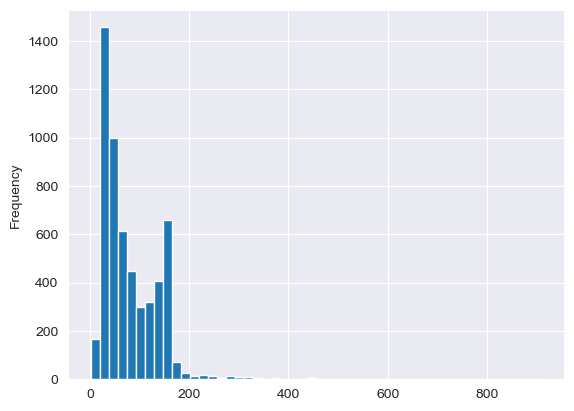

In [6]:
messages['length'].plot(bins=50, kind='hist')

array([<AxesSubplot: title={'center': 'ham'}>,
       <AxesSubplot: title={'center': 'spam'}>], dtype=object)

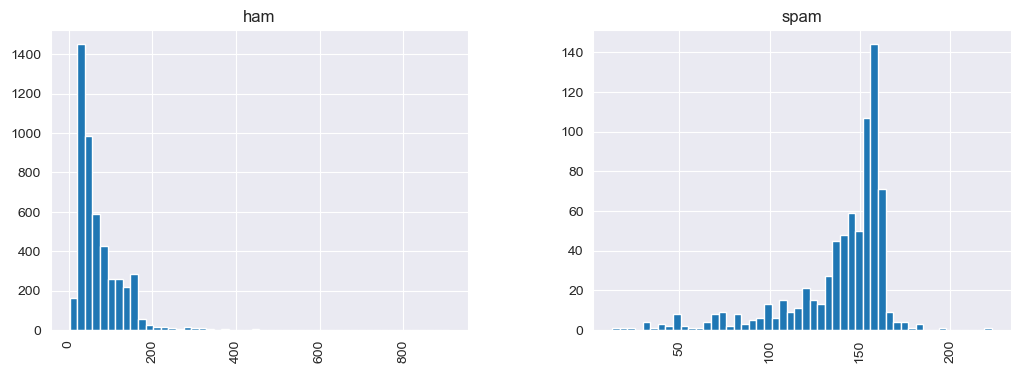

In [7]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

We see, that SPAM or HAM messages slightly depend on message length
Let's make some text preprocessing

In [11]:
import nltk
import string
from nltk.corpus import stopwords

In [12]:
def text_process(mess):
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)

    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [13]:
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

After preprocessing let's vectorize our data

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])
messages_bow = bow_transformer.transform(messages['message'])

Now, we'll use TdIdfTransformer

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)

And now - we'll train the model

In [22]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])
all_predictions = spam_detect_model.predict(messages_tfidf)

In [24]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.2)

We'll use a data Pipeline

In [25]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [26]:
pipeline.fit(msg_train,label_train)
predictions = pipeline.predict(msg_test)

In [32]:
from sklearn.metrics import classification_report
print(classification_report(predictions,label_test))


              precision    recall  f1-score   support

         ham       1.00      0.95      0.97      1021
        spam       0.65      1.00      0.79        94

    accuracy                           0.95      1115
   macro avg       0.82      0.98      0.88      1115
weighted avg       0.97      0.95      0.96      1115

